In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['JNJ.csv']))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Saving JNJ.csv to JNJ.csv


In [ ]:
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
features = np.nan_to_num(features)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 3])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, sequence_length)

train_size = int(len(X) * 0.8)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [ ]:
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
352/352 [==============================] - 30s 70ms/step - loss: 0.3892 - val_loss: 0.1399 - lr: 5.0000e-04
Epoch 2/50
352/352 [==============================] - 23s 67ms/step - loss: 0.1977 - val_loss: 0.0654 - lr: 5.0000e-04
Epoch 3/50
352/352 [==============================] - 23s 65ms/step - loss: 0.1150 - val_loss: 0.0459 - lr: 5.0000e-04
Epoch 4/50
352/352 [==============================] - 25s 70ms/step - loss: 0.0704 - val_loss: 0.0378 - lr: 5.0000e-04
Epoch 5/50
352/352 [==============================] - 24s 68ms/step - loss: 0.0454 - val_loss: 0.0306 - lr: 5.0000e-04
Epoch 6/50
352/352 [==============================] - 22s 64ms/step - loss: 0.0316 - val_loss: 0.0240 - lr: 5.0000e-04
Epoch 7/50
352/352 [==============================] - 24s 67ms/step - loss: 0.0234 - val_loss: 0.0199 - lr: 5.0000e-04
Epoch 8/50
352/352 [==============================] - 24s 67ms/step - loss: 0.0180 - val_loss: 0.0156 - lr: 5.0000e-04
Epoch 9/50
352/352 [============================

In [ ]:
predicted_prices = model.predict(test_X)
predicted_prices_extended = np.zeros((predicted_prices.shape[0], scaled_features.shape[1]))
predicted_prices_extended[:, 3] = predicted_prices[:, 0]
predicted_prices = scaler.inverse_transform(predicted_prices_extended)[:, 3]

test_y_extended = np.zeros((test_y.shape[0], scaled_features.shape[1]))
test_y_extended[:, 3] = test_y
real_prices = scaler.inverse_transform(test_y_extended)[:, 3]

98/98 [==============================] - 3s 17ms/step


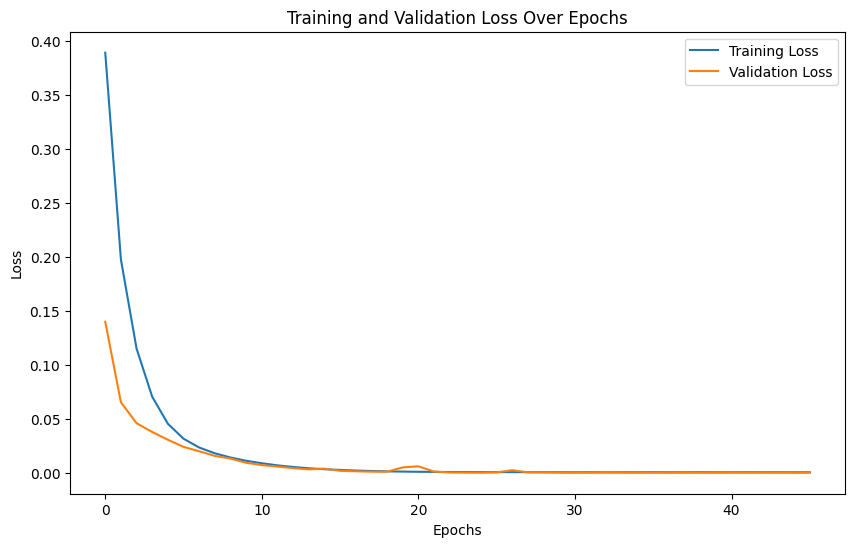

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

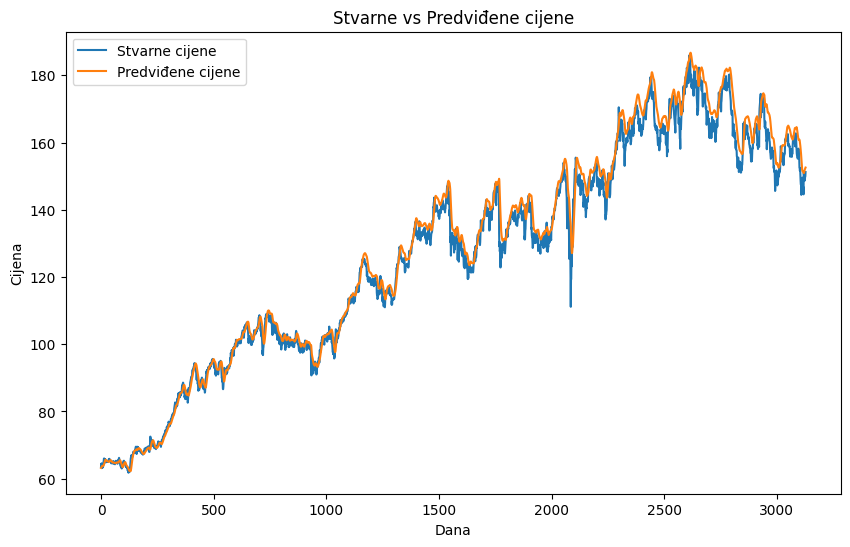

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Stvarne cijene')
plt.plot(predicted_prices, label='Predviđene cijene')
plt.title('Stvarne vs Predviđene cijene')
plt.xlabel('Dana')
plt.ylabel('Cijena')
plt.legend()
plt.show()

In [ ]:
def predict_future_prices(model, data, days=30, sequence_length=60):
    future_predictions = []
    current_sequence = data[-sequence_length:]

    for _ in range(days):
        current_sequence_reshaped = current_sequence.reshape((1, sequence_length, data.shape[1]))
        future_price = model.predict(current_sequence_reshaped)[0, 0]

        future_predictions.append(future_price)

        new_sequence_element = np.append(current_sequence[-1, :-1], future_price)
        current_sequence = np.append(current_sequence[1:], new_sequence_element.reshape((1, data.shape[1])), axis=0)

    return future_predictions

In [ ]:
future_days = 30
future_predictions = predict_future_prices(model, scaled_features, days=future_days)
future_predictions = scaler.inverse_transform(np.concatenate(
    (np.zeros((future_days, 3)), np.array(future_predictions).reshape(-1, 1), np.zeros((future_days, 1))), axis=1))[:, 3]

1/1 [==============================] - 0s 30ms/step


In [ ]:
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=future_days + 1, inclusive='right')

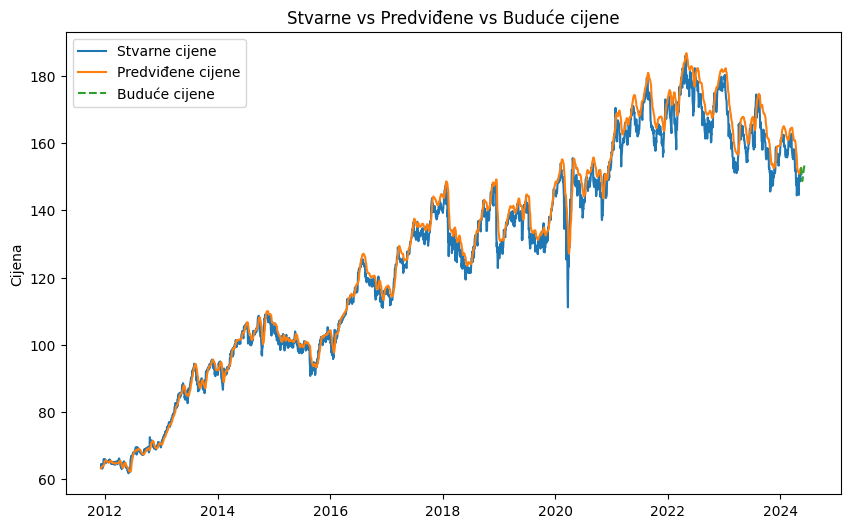

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(real_prices):], real_prices, label='Stvarne cijene')
plt.plot(df.index[-len(predicted_prices):], predicted_prices, label='Predviđene cijene')
plt.plot(future_dates, future_predictions, label='Buduće cijene', linestyle='--')
plt.title('Stvarne vs Predviđene vs Buduće cijene')
plt.ylabel('Cijena')
plt.legend()
plt.show()